## 檢視 GPU

In [1]:
! nvidia-smi

Tue May 30 09:10:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 資料讀取

In [2]:
! wget https://github.com/ywchiu/tiandiren_tf/raw/main/data/captcha_jpg.zip

--2023-05-30 09:12:30--  https://github.com/ywchiu/tiandiren_tf/raw/main/data/captcha_jpg.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ywchiu/tiandiren_tf/main/data/captcha_jpg.zip [following]
--2023-05-30 09:12:30--  https://raw.githubusercontent.com/ywchiu/tiandiren_tf/main/data/captcha_jpg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818150 (3.6M) [application/zip]
Saving to: ‘captcha_jpg.zip’

captcha_jpg.zip     100%[===================>]   3.64M  --.-KB/s    in 0.01s   

2023-05-30 09:12:30 (296 MB/s) - ‘captcha_jpg.zip’ saved [3818150/3818150]



In [ ]:
! unzip captcha_jpg.zip

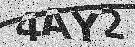

In [4]:
from PIL import Image
a = Image.open('data/1.jpg')
a

In [7]:
import numpy as np
img_ary = np.array(a)
img_ary.shape

(47, 135, 3)

In [8]:
height, width = 47,135

## 預處理

In [23]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
height, width = 47,135
n_len = 4
n_class = 36

## 建立 VGG 16 模型

In [10]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

input_tensor = Input((height, width, 3))
x = input_tensor

for i, n_cnn in enumerate([2, 2, 2, 2]):
  for j in range(n_cnn):
    x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47, 135, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 47, 135, 32)  896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 135, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 讀取標注資料

In [13]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tiandiren_tf/main/data/output_captua.csv', index_col = 0)
df.head()

,captcua,file
0.0,4ay2,1.0
2.0,qmqh,2.0
4.0,kc3c,3.0
6.0,1549,4.0
8.0,5rqz,5.0


In [14]:
df.dropna(inplace = True)

In [16]:
df['file'] = df['file'].map(lambda e: 'data/{}.jpg'.format(int(e)))

In [17]:
df.head()

,captcua,file
0.0,4ay2,data/1.jpg
2.0,qmqh,data/2.jpg
4.0,kc3c,data/3.jpg
6.0,1549,data/4.jpg
8.0,5rqz,data/5.jpg


In [18]:
df = df[df.index.notnull()]
df.reset_index(inplace=True)
del df['index']

In [19]:
df.head()

,captcua,file
0,4ay2,data/1.jpg
1,qmqh,data/2.jpg
2,kc3c,data/3.jpg
3,1549,data/4.jpg
4,5rqz,data/5.jpg


In [20]:
df.columns = ['captcha', 'file']
df.head()

,captcha,file
0,4ay2,data/1.jpg
1,qmqh,data/2.jpg
2,kc3c,data/3.jpg
3,1549,data/4.jpg
4,5rqz,data/5.jpg


## 準備訓練資料

In [21]:
X = np.zeros((len(df), height, width, 3), dtype=np.float32)
y = [np.zeros((len(df), n_class), dtype=np.uint8) for i in range(n_len)]


In [24]:
for i in df.index:
    random_str = df.loc[i,'captcha']
    fname = df.loc[i,'file']

    f1 = Image.open(fname)
    f1 = f1.resize((width, height))
    ary = np.array(f1)

    X[i] = ary * 1.0 / 255.0
    for j, ch in enumerate(random_str):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [25]:
X.shape

(439, 47, 135, 3)

In [26]:
len(y)

4

In [28]:
y[0][0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

## 資料產生函數

In [30]:
import random
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            rand_index = random.choice(df.index)
            random_str = df.loc[rand_index,'captcha']
            fname = df.loc[rand_index,'file']

            f1 = Image.open(fname)
            f1 = f1.resize((width, height))
            ary = np.array(f1)

            X[i] = ary / 255.0

            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

## 模型訓練

In [31]:
from keras import callbacks
cbks = [callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)]


In [32]:
history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                    epochs=5,                # 總共跑5個訓練循環
                    steps_per_epoch=1000,
                    callbacks=cbks,          # 保存最好的模型到檔案
                    validation_data=gen(),   # 驗證資料也是用生成器來產生
                    validation_steps=40      # 用40組資料來驗證
                   ) 

<ipython-input-32-5f812ce10ff8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料


Epoch 1/5
1000/1000 [==============================] - 56s 38ms/step - loss: 0.6812 - c1_loss: 0.1501 - c2_loss: 0.3158 - c3_loss: 0.1170 - c4_loss: 0.0984 - c1_accuracy: 0.9709 - c2_accuracy: 0.9486 - c3_accuracy: 0.9780 - c4_accuracy: 0.9811 - val_loss: 0.6217 - val_c1_loss: 0.0948 - val_c2_loss: 0.3464 - val_c3_loss: 0.1215 - val_c4_loss: 0.0590 - val_c1_accuracy: 0.9836 - val_c2_accuracy: 0.9281 - val_c3_accuracy: 0.9891 - val_c4_accuracy: 0.9977
Epoch 2/5
1000/1000 [==============================] - 38s 38ms/step - loss: 0.2526 - c1_loss: 0.0303 - c2_loss: 0.1946 - c3_loss: 0.0172 - c4_loss: 0.0104 - c1_accuracy: 0.9895 - c2_accuracy: 0.9693 - c3_accuracy: 0.9949 - c4_accuracy: 0.9977 - val_loss: 0.3389 - val_c1_loss: 0.0444 - val_c2_loss: 0.2595 - val_c3_loss: 0.0253 - val_c4_loss: 0.0097 - val_c1_accuracy: 0.9859 - val_c2_accuracy: 0.9617 - val_c3_accuracy: 0.9937 - val_c4_accuracy: 0.9984
Epoch 3/5
1000/1000 [==============================] - 39s 39ms/step - loss: 0.2055 - c1_l

## 測試模型預測能力

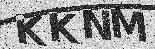

In [33]:
img = Image.open('data/345.jpg')
img

In [34]:
ary = np.array(img.resize((width, height)))
ary = ary * 1.0 / 255.0

In [35]:
ary.shape

(47, 135, 3)

In [36]:
ary = ary.reshape((1,height, width, 3))

In [37]:
ary.shape

(1, 47, 135, 3)

In [39]:
[np.argmax(e) for e in model.predict(ary)]

1/1 [==============================] - 0s 21ms/step


[20, 20, 23, 22]

In [40]:
characters

'0123456789abcdefghijklmnopqrstuvwxyz'

In [41]:
[characters[np.argmax(e)] for e in model.predict(ary)]

1/1 [==============================] - 0s 34ms/step


['k', 'k', 'n', 'm']

## 模型儲存

In [71]:
model.save('model.h5')

## 模型載入

In [78]:
import tensorflow as tf
model2 = tf.keras.models.load_model('model.h5')
model2

In [79]:
model2.evaluate(X,y)

14/14 [==============================] - 1s 17ms/step - loss: 0.0735 - c1_loss: 0.0180 - c2_loss: 0.0412 - c3_loss: 0.0088 - c4_loss: 0.0055 - c1_accuracy: 0.9909 - c2_accuracy: 0.9909 - c3_accuracy: 0.9932 - c4_accuracy: 0.9977


[0.07353955507278442,
 0.0180477574467659,
 0.041173938661813736,
 0.008820480667054653,
 0.005497377831488848,
 0.9908883571624756,
 0.9908883571624756,
 0.9931662678718567,
 0.9977220892906189]

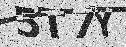

In [80]:
img = Image.open('data/238.jpg')
img

In [81]:
ary = np.array(img.resize((width, height)))
ary = ary * 1.0 / 255.0

In [82]:
ary = ary.reshape((1,height, width, 3))

In [83]:
[characters[np.argmax(e)] for e in model2.predict(ary)]

1/1 [==============================] - 1s 517ms/step


['5', 't', '7', 'y']

## 使用Flask 搭建 API

In [84]:
from flask import Flask
app = Flask(__name__)

@app.route("/")
def hello():
    return "Hello World!"

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [85]:
from flask import Flask
from flask import request
from flask import jsonify

from tensorflow.keras.models import load_model

app = Flask(__name__)

m = load_model('model.h5')

@app.route("/submit", methods=['POST'])
def hello():
  val = request.values['data']
  res = m.predict(val)
  return jsonify({'result': res})
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
